# Hurst Exponents estimation in a multifractional Brownian motion

## Estimation of time-dependent Hurst exponents with variational smoothing

[github.com/SarahFrem/Quant-Hurst_exponents](https://github.com/SarahFrem/Quant-Hurst_exponents)

Based on [Mr Matthieu Garcin](https://www.researchgate.net/profile/Matthieu-Garcin) research paper:
[Estimation of time-dependent Hurst exponents with variational smoothing and application to forecasting foreign exchange rates (2017 Elsevier B.V)](https://www.researchgate.net/publication/310705816_Estimation_of_time-dependent_Hurst_exponents_with_variational_smoothing_and_application_to_forecasting_foreign_exchange_rates) 

local copy: [Hurstdynamique.v3.HAL.pdf](./Hurstdynamique.v3.HAL.pdf)

_What's a standard brownian motion $W_t$ in a few properties:_
- $𝑊_0 = 0$
- $𝑊_𝑡$ continuous
- Increments are independant
- $𝑊_𝑡 – 𝑊_𝑠 \sim N(0, t-s), 0 \le s \le t$
		
_What's a fractional brownian motion $W_t$ in a few additonal properties:_
- $Ε[(W_{𝑡} – 𝑊_{𝑠})^{2}]= 𝜎^{2}|𝑡−𝑠|^{2𝐻}$
- $Ε[W_{t},W_{s}]= 𝜎^{2}(|𝑡|^{2𝐻}+|𝑠|^{2𝐻}−|𝑡−𝑠|^{2𝐻})$
- Increments are correlated with a $H \neq \frac{1}{2}$

_What's then a multifractional brownian motion:_
- Hurst Exponents are time-dependent
- $Ε[𝑊_{𝑡},𝑊_{𝑠}]=\frac{𝜎^{2}}{2}\cdot 𝑔(𝐻_{𝑡}+𝐻_{𝑠})\cdot (|𝑡|^{𝐻_{𝑡}+𝐻_{𝑠}}+|𝑠|^{𝐻_{𝑡}+𝐻_{𝑠}}−|𝑡−𝑠|^{𝐻_{𝑡}+𝐻{𝑠}})$

Here $g(H_{t}, H_{s}) = \frac{\sqrt{K(2H_{t})K(2H_{s})}}{K(H_{t}+H_{s})}$ and $K(\alpha) = \Gamma(1 + \alpha)\frac{\sin(\alpha \pi/2)}{\pi}$

The paper gives a method called variational smooting for estimating time-dependent Hurst exponents:
  - Study case on simulated MbM
  - Study case on 15 min basis FX market time series where the observation of a long memory leads to the key hypothesis: those time series are driven by an underneath MbM.  

In [46]:
import numpy as np
import pandas as pd
from fbm import FBM, times, fbm, fgn
from mbm import MBM, mbm, mgn
import matplotlib.pyplot as plt

# The following allows to save plots in SVG format.
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# 1. A simulation study
## 1.1 mBm with affine Hurst funciton

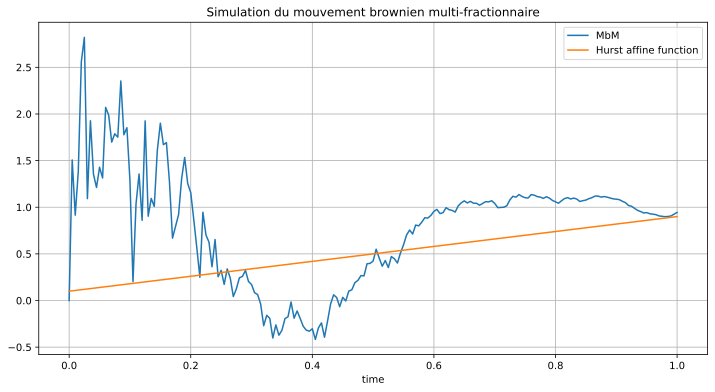

In [47]:
FIGSIZE = (12,6) # (15,8) (10,6)
N = 200 # nombre de steps

def affine_h(t): return 0.1 + 0.8*t

np.random.seed(0)
s_aff = mbm(n=N, hurst=affine_h, length=1, method='riemannliouville')
t_aff = times(n=N, length=1)
affine = affine_h(t_aff)

plt.figure(figsize=FIGSIZE)
plt.plot(t_aff, s_aff)
plt.plot(t_aff, affine)
plt.xlabel('time')
plt.legend(['MbM','Hurst affine function'], loc='best')
plt.title('Simulation du mouvement brownien multi-fractionnaire')
plt.grid()
plt.show()


### 1.1.2 Estimation of Hurst exponent

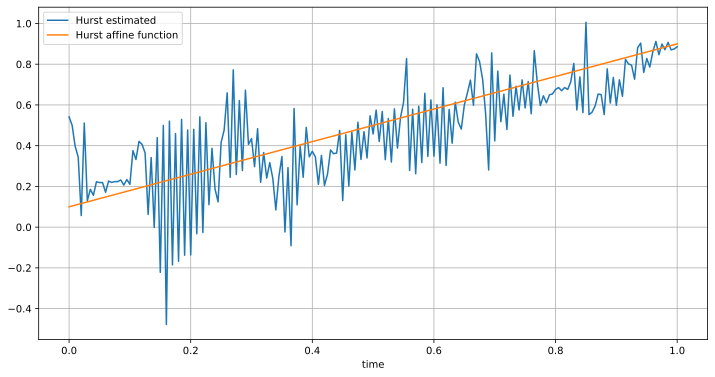

In [48]:
def computing_M(k, epsilon, s_aff):
    M = np.zeros((len(s_aff), 1))

    for tt in range(0, len(s_aff)):
        if tt < epsilon: 
            n = 0
        else : 
            n = tt - (epsilon-1)
        sum = 0.0    
        for i in range(n + 1, tt+1):
            sum = sum + np.power(abs(s_aff[i] - s_aff[i-1]) , k)  
            if tt < epsilon: 
                M[tt] = sum /tt 
            else:
                M[tt] = sum / (tt - n + 1)
    return M

def computing_M_prime(k, epsilon, s_aff):
    M_bis = np.zeros((len(s_aff), 1))
    
    for tt in range(0, len(s_aff)):
        
        if tt < epsilon: 
            n = 0
        else : 
            n = tt - (epsilon-1)
        sum = 0.0    
        for i in range(n+1, tt+1,2):
            if tt < epsilon: 
                if i>2:
                    sum = sum + np.power(abs(s_aff[i] - s_aff[i-2]) , k)  # moment 2
                else:
                    sum = sum + np.power(abs(s_aff[i]) , k)
                M_bis[tt] = 2*sum /tt
            else:
                sum = sum + np.power(abs(s_aff[i] - s_aff[i-2]) , k) 
                M_bis[tt] = 2*sum / (tt - n + 1)
    return M_bis

# computing hurst estimated
def computing_h_estimated(k, epsilon, s_aff):
    M = computing_M(k, epsilon, s_aff)
    M_bis = computing_M_prime(k, epsilon, s_aff)
    H_estimated = 0.5 * np.log2(M_bis[1:]/M[1:])
    ct = H_estimated[42]
    H_estimated = np.insert(H_estimated, 0, ct)
    
    return H_estimated

epsilon = 26 # nombre d'observations
k = 2 # moment d'ordre 2
H_estimated = computing_h_estimated(k, epsilon, s_aff)

plt.figure(figsize=FIGSIZE)
plt.plot(t_aff, H_estimated)
plt.plot(t_aff, affine)
plt.xlabel('time')
plt.legend(['Hurst estimated','Hurst affine function'], loc='best')
plt.grid()
plt.show()

### 1.1.3 Estimation of Hurst exponent smoothed (discretized version)

       affine  H_estimated  H_smoothed_discretized
0.000   0.100     0.541306                0.224427
0.005   0.104     0.500000                0.226004
0.010   0.108     0.396747                0.227239
0.015   0.112     0.344184                0.228261
0.020   0.116     0.057045                0.229139


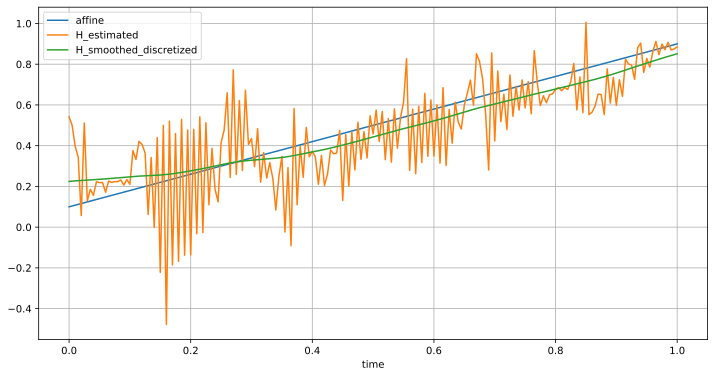

In [49]:
def computing_phi_H_estimated(param_lambda, H_estimated, t_aff):
    phi_h_estimated =  np.zeros((len(t_aff), 1))
    param = np.sqrt(param_lambda)

    for i in range(0, len(t_aff)):
        sum1 = 0.0
        sum2 = 0.0
        for j in range(0,i+1):
            if j == 0: # case V0
                Vj = (t_aff[1] - t_aff[0] ) / 2
            elif j == len(t_aff) - 1 : #case j = N (199)
                Vj = (t_aff[j] - t_aff[j - 1] ) / 2
            else : 
                Vj = (t_aff[j + 1] - t_aff[j - 1] ) / 2

            sum1 = sum1 + np.exp(-t_aff[j] / param) * H_estimated[j] * Vj
            sum2 = sum2 + np.exp(t_aff[j] / param) * H_estimated[j] * Vj
        phi_h_estimated[i] = (-np.exp(t_aff[i]/param) / (2*param)) * sum1 + (+np.exp(-t_aff[i]/param) / (2*param)) * sum2
    
    return phi_h_estimated

LAMBDA = 0.02
phi_h_estimated = computing_phi_H_estimated(LAMBDA, H_estimated, t_aff)

def computing_alpha(t_aff, param_lambda, start_window=0, n_window=len(t_aff)):
    #print('n_window', str(n_window))
    #print('start_window', str(start_window))
    param = np.sqrt(param_lambda)
    sum1 = 0.0
    sum2 = 0.0
    for i in range(start_window+1, n_window):
        sum1 = sum1 + np.exp(2*t_aff[i]/param)
        sum2 = sum2 + np.exp(-2*t_aff[i]/param)
    alpha = sum1 * sum2 - np.square((n_window - start_window) - 1) 
    return alpha

# Computing A and B
def computing_A_B(t_aff, param_lambda, H_estimated, phi_h_estimated, start_window=0, n_window=len(t_aff)):
    sumA_1 = 0.0
    sumA_2 = 0.0
    sumB = 0.0
    sum2 = 0.0
    sum1 = 0.0
    
    alpha = computing_alpha(t_aff, param_lambda, start_window, n_window)
    
    param = np.sqrt(param_lambda)
    
    for i in range(start_window+1, n_window):
        sumA_1 = sumA_1 + (np.exp(t_aff[i]/param) * (H_estimated[i] -phi_h_estimated[i] ))
        sumA_2 = sumA_2 + (np.exp( - t_aff[i]/param) * (H_estimated[i] -phi_h_estimated[i] ))
        sum1 = sum1 + np.exp(2*t_aff[i]/param)
        sum2 = sum2 + np.exp(-2*t_aff[i]/param)
        
    A = (1/alpha) * ( sum2 * sumA_1 - ((n_window - start_window - 1 ) * sumA_2)) 
    B = (1/alpha) * ( sum1 * sumA_2 - ((n_window - start_window - 1 ) * sumA_1)) 
    
    return A, B

def computing_H_smoothed(t_aff, param_lambda, H_estimated, phi_h_estimated, start_window=0, n_window=len(t_aff)):
    A, B = computing_A_B(t_aff, param_lambda, H_estimated, phi_h_estimated, start_window, n_window)
    
    param = np.sqrt(param_lambda)
    H_smoothed_discretized =  np.zeros((n_window - start_window, 1))

    for i in range(start_window, n_window):
        H_smoothed_discretized[i - start_window] = phi_h_estimated[i] + A*np.exp(t_aff[i]/param) + B*np.exp(-t_aff[i]/param)
        
    return H_smoothed_discretized

H_smoothed_discretized = computing_H_smoothed(t_aff, LAMBDA, H_estimated, phi_h_estimated)
df_results = pd.DataFrame({'affine': affine.ravel(), 'H_estimated': H_estimated.ravel(), 'H_smoothed_discretized': H_smoothed_discretized.ravel()}, index = t_aff)
print(df_results.head())

df_results.plot(figsize=FIGSIZE)
plt.xlabel('time')
plt.grid()
plt.show()


### 1.1.4 exponentially weighted moving average

       affine  H_estimated  H_smoothed_discretized       emw
0.000   0.100     0.541306                0.224427  0.541306
0.005   0.104     0.500000                0.226004  0.539654
0.010   0.108     0.396747                0.227239  0.533937
0.015   0.112     0.344184                0.228261  0.526347
0.020   0.116     0.057045                0.229139  0.507575


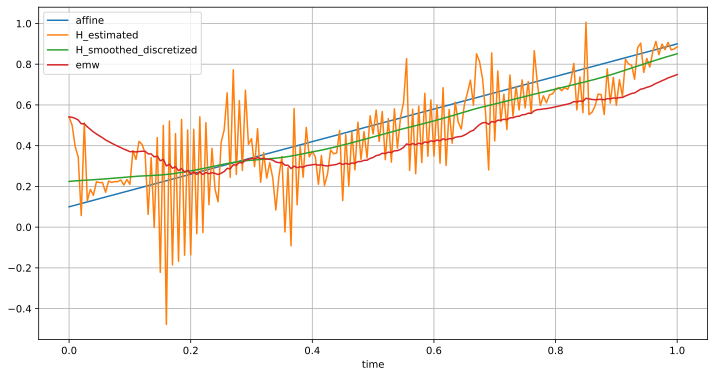

In [50]:
param_ewm = 0.04
def computing_ewm(param_ewm, H_estimated):
    df = pd.DataFrame({'H_estimated' : H_estimated})
    ewm = df.H_estimated.ewm(alpha=param_ewm, adjust=False).mean().tolist()
    return ewm

df_results['emw'] = computing_ewm(param_ewm, df_results.H_estimated.values)
print(df_results.head())

df_results.plot(figsize=FIGSIZE)
plt.xlabel('time')
plt.grid()
plt.show()

### 1.1.5 Metrics

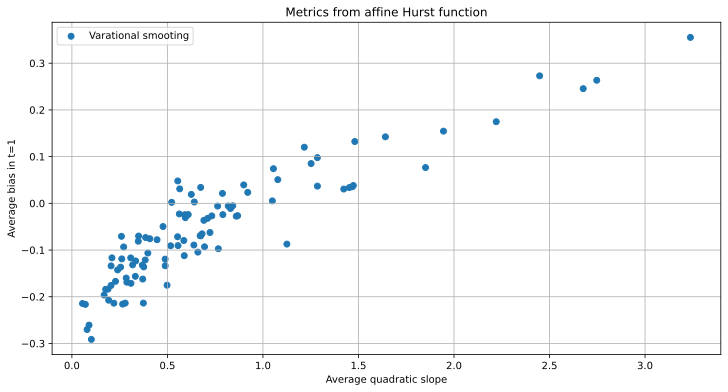

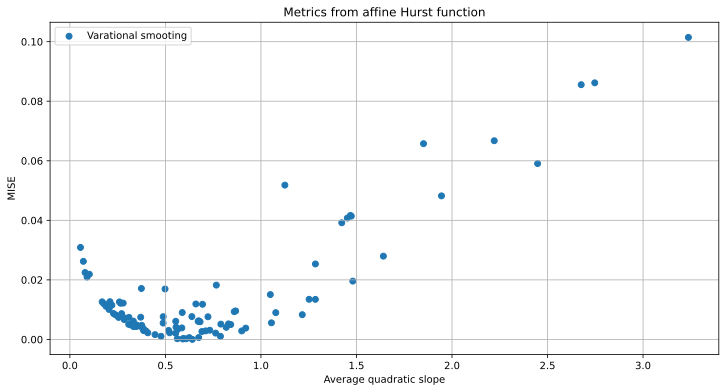

In [52]:
parameters_smoothing = np.arange(0.02, 280, 2.828)
parameters_emw = np.arange(0.01, 0.05, 0.00040404)

R0_smoothed = np.zeros((len(parameters_smoothing), 1))
R0_emw = np.zeros((len(parameters_emw), 1))

R1_smoothed = np.zeros((len(parameters_smoothing), 1))
R1_emw = np.zeros((len(parameters_emw), 1))

R2_smoothed = np.zeros((len(parameters_smoothing), 1))
R2_emw = np.zeros((len(parameters_emw), 1))

for index in range(0,len(parameters_smoothing)):
 
    lambda_ = parameters_smoothing[index]
    lambda_emw = parameters_emw[index]
    
    #np.random.seed(0)
    s_aff_simul = mbm(n=N, hurst=affine_h, length=1, method='riemannliouville')
    t_aff_simul = times(n=N, length=1)
    
    H_estimated_simul = computing_h_estimated(k, epsilon, s_aff_simul)
    phi_h_estimated_simul = computing_phi_H_estimated(lambda_, H_estimated_simul, t_aff_simul)
    H_smoothed_discretized_simul = computing_H_smoothed(t_aff_simul, lambda_, H_estimated_simul, phi_h_estimated_simul)
    emw_simul = computing_ewm(lambda_emw, H_estimated_simul)
    
    #computing R0
    sum_diff_smoothed = 0.0
    sum_diff_emw = 0.0
    for i in range(1, len(t_aff_simul)):
        sum_diff_smoothed = sum_diff_smoothed + np.square(H_smoothed_discretized_simul[i] - affine[i])
        sum_diff_emw = sum_diff_emw + np.square(emw_simul[i] - affine[i])  
    R0_smoothed[index] = (1/len(t_aff_simul)) *  sum_diff_smoothed
    R0_emw[index] = (1/len(t_aff_simul)) *  sum_diff_emw
    
    # computing R2
    sum_diff_index_smoothed = 0.0
    sum_diff_index_emw = 0.0 
    for i in range(2, len(t_aff_simul)):
        sum_diff_index_smoothed = sum_diff_index_smoothed + np.square(((H_smoothed_discretized_simul[i] - H_smoothed_discretized_simul[i-1]) * len(t_aff_simul)))
        sum_diff_index_emw = sum_diff_index_emw + np.square(((emw_simul[i] - emw_simul[i-1]) * len(t_aff_simul)))
    R2_smoothed[index] = (1/(len(t_aff_simul)-1)) *  sum_diff_index_smoothed
    R2_emw[index] = (1/(len(t_aff_simul)-1)) *  sum_diff_index_emw
    
    # Computing R1
    R1_smoothed[index] = H_smoothed_discretized_simul[len(t_aff_simul)-1] - affine[len(t_aff_simul)-1]
    R1_emw[index] = emw_simul[len(t_aff_simul) - 1] - affine[len(t_aff_simul) - 1]
    
df_metrics = pd.DataFrame({'R0_smoothed': R0_smoothed.ravel(), 'R0_emw': R0_emw.ravel(), 'R1_smoothed': R1_smoothed.ravel(), 'R1_emw': R1_emw.ravel(), 'R2_smoothed': R2_smoothed.ravel(), 'R2_emw': R2_emw.ravel()}, index = R0_smoothed.ravel())

plt.figure(figsize=FIGSIZE)
plt.scatter(df_metrics.R2_smoothed.values, df_metrics.R1_smoothed.values)
plt.title('Metrics from affine Hurst function')
plt.legend(['Varational smooting','Exp moving avg'], loc='best')
plt.xlabel('Average quadratic slope')
plt.ylabel('Average bias in t=1')
plt.grid()
plt.show()

plt.figure(figsize=FIGSIZE)
plt.scatter(df_metrics.R2_smoothed.values, df_metrics.R0_smoothed.values)
plt.title('Metrics from affine Hurst function')
plt.legend(['Varational smooting','Exp moving avg'], loc='best')
plt.xlabel('Average quadratic slope')
plt.ylabel('MISE')
plt.grid()
#plt.savefig('metrics_affine_together_1.svg')
plt.show()

## 1.2 mBm with exponential Hurst function

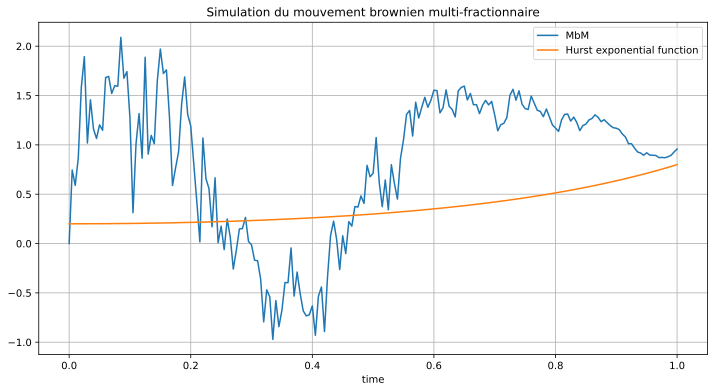

In [53]:
def exponential_h(t):
    return 0.2 + 0.6*((np.exp(t*t) - 1 )/ (np.exp(1) - 1))

np.random.seed(0)
s_exp = mbm(n=N, hurst=exponential_h, length=1, method='riemannliouville')
t_exp = times(n=N, length=1)
exponential = exponential_h(t_exp)

plt.figure(figsize=FIGSIZE)
plt.plot(t_exp, s_exp)
plt.plot(t_exp, exponential)
plt.xlabel('time')
plt.legend(['MbM','Hurst exponential function'], loc='best')
plt.title('Simulation du mouvement brownien multi-fractionnaire')
plt.grid()
plt.show()

### 1.2.1 Estimation of Hurst exponent

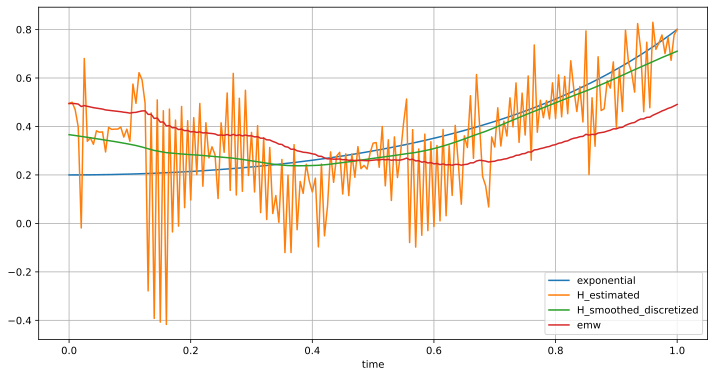

In [54]:
H_estimated_exp = computing_h_estimated(k, epsilon, s_exp)
phi_h_estimated_exp = computing_phi_H_estimated(LAMBDA, H_estimated_exp, t_exp)
H_smoothed_discretized_exp = computing_H_smoothed(t_exp, LAMBDA, H_estimated_exp, phi_h_estimated_exp)
emw_exp = computing_ewm(LAMBDA, H_estimated_exp)

df_results_exp = pd.DataFrame({'exponential': exponential.ravel(), 'H_estimated': H_estimated_exp.ravel(), 'H_smoothed_discretized': H_smoothed_discretized_exp.ravel(), 'emw': emw_exp}, index = t_exp)

df_results_exp.plot(figsize=FIGSIZE)
plt.xlabel('time')
plt.grid()
plt.show()

### 1.2.2 Metrics (exponential)

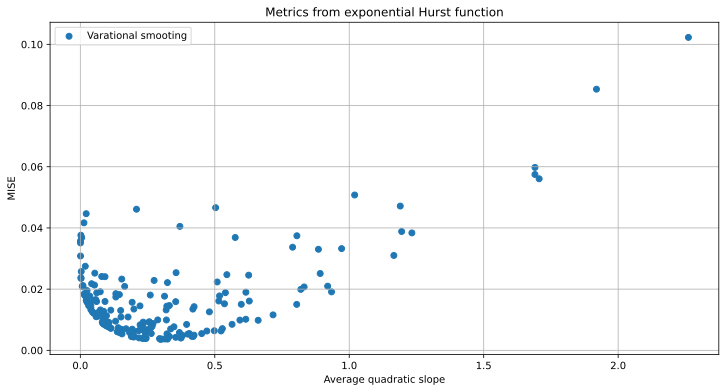

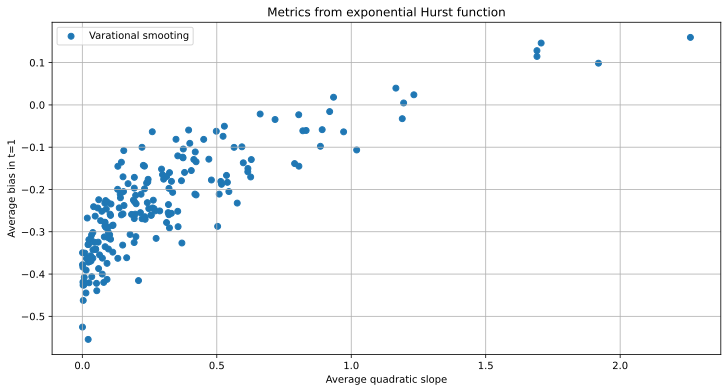

In [55]:
# variation des parametres 
parameters_smoothing_exp = np.linspace(0.02, 280, 200)
parameters_emw_exp = np.linspace(0.01, 0.05, 200)

R0_smoothed_exp = np.zeros((len(parameters_smoothing_exp)))
R0_emw_exp = np.zeros((len(parameters_emw_exp)))

R1_smoothed_exp = np.zeros((len(parameters_smoothing_exp)))
R1_emw_exp = np.zeros((len(parameters_emw_exp)))

R2_smoothed_exp = np.zeros((len(parameters_smoothing_exp)))
R2_emw_exp = np.zeros((len(parameters_emw_exp)))

for index in range(0,len(parameters_smoothing_exp)):
    lambda__exp = parameters_smoothing_exp[index]
    lambda_emw_exp = parameters_emw_exp[index]
    
    #np.random.seed(0)
    s_exp = mbm(n=N, hurst=exponential_h, length=1, method='riemannliouville')
    t_exp = times(n=N, length=1)

    H_estimated_exp = computing_h_estimated(k, epsilon, s_exp)
    phi_h_estimated_exp = computing_phi_H_estimated(lambda__exp, H_estimated_exp, t_exp)
    H_smoothed_discretized_exp = computing_H_smoothed(t_exp, lambda__exp, H_estimated_exp, phi_h_estimated_exp)
    emw_exp = computing_ewm(lambda_emw_exp, H_estimated_exp)
    
    #computing R0
    sum_diff_smoothed_exp = 0.0
    sum_diff_emw_exp = 0.0
    for i in range(1, len(t_exp)):
        sum_diff_smoothed_exp = sum_diff_smoothed_exp + np.square(H_smoothed_discretized_exp[i] - exponential[i])
        sum_diff_emw_exp = sum_diff_emw_exp + np.square(emw_exp[i] - exponential[i])  
    R0_smoothed_exp[index] = (1/len(t_exp)) *  sum_diff_smoothed_exp
    R0_emw_exp[index] = (1/len(t_exp)) *  sum_diff_emw_exp
    
    # computing R2
    sum_diff_index_smoothed_exp = 0.0
    sum_diff_index_emw_exp = 0.0 
    for i in range(2, len(t_exp)):
        sum_diff_index_smoothed_exp = sum_diff_index_smoothed_exp + np.square(((H_smoothed_discretized_exp[i] - H_smoothed_discretized_exp[i-1]) * len(t_exp)))
        sum_diff_index_emw_exp = sum_diff_index_emw_exp + np.square(((emw_exp[i] - emw_exp[i-1]) * len(t_exp)))
    R2_smoothed_exp[index] = (1/(len(t_exp)-1)) *  sum_diff_index_smoothed_exp
    R2_emw_exp[index] = (1/(len(t_exp)-1)) *  sum_diff_index_emw_exp
    
    # Computing R1
    R1_smoothed_exp[index] = H_smoothed_discretized_exp[len(t_exp)-1] - exponential[len(t_exp)-1]
    R1_emw_exp[index] = emw_exp[len(t_exp) - 1] - exponential[len(t_exp) - 1]

df_metrics_exp = pd.DataFrame({'R0_smoothed': R0_smoothed_exp, 'R0_emw': R0_emw_exp, 'R1_smoothed': R1_smoothed_exp, 'R1_emw': R1_emw_exp, 'R2_smoothed': R2_smoothed_exp, 'R2_emw': R2_emw_exp}, index = R0_smoothed_exp.ravel())

plt.figure(figsize=FIGSIZE)
plt.scatter(df_metrics_exp.R2_smoothed, df_metrics_exp.R0_smoothed)
plt.title('Metrics from exponential Hurst function')
plt.legend(['Varational smooting','Exp moving avg'], loc='best')
plt.xlabel('Average quadratic slope')
plt.ylabel('MISE')
plt.grid()
plt.show()

plt.figure(figsize=FIGSIZE)
plt.scatter(df_metrics_exp.R2_smoothed, df_metrics_exp.R1_smoothed)
plt.title('Metrics from exponential Hurst function')
plt.legend(['Varational smooting','Exp moving avg'], loc='best')
plt.xlabel('Average quadratic slope')
plt.ylabel('Average bias in t=1')
plt.grid()
plt.show()

# 2. Prices of exchange rates
## 2.1 Importattion des data

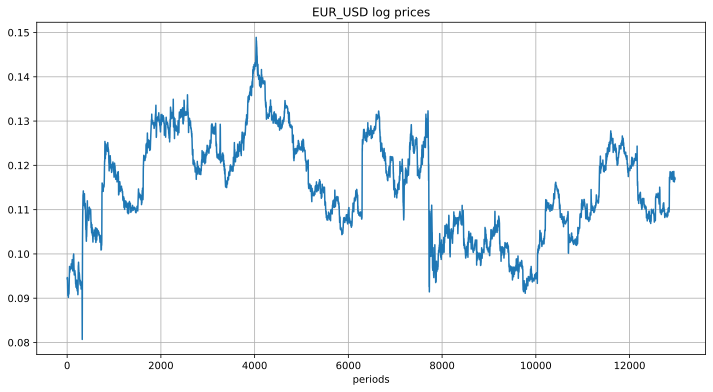

In [56]:
PATH = './'
data_forex_files = {'EUR_GBP' : 'EURGBP.xlsx', 'EUR_USD' : 'EURUSD.xlsx'}

# average between the highest and lowest rate in each 15 min time interval
data_forex = {}
for forex, file in data_forex_files.items():
    df = pd.read_excel(str(PATH+file), skiprows=0, index_col=0).dropna(axis=0)   
    if 'Haut' in df.columns:
        data_forex[forex] = pd.DataFrame({forex:np.log(((df['Haut'] + df['Bas']) / 2).values)}, index=df.index) 
    else:
        data_forex[forex] = pd.DataFrame({forex: np.log(((df['High'] + df['Low']) / 2).values)}, index=df.index)

# example d'une serie : 
serie_  = 'EUR_USD'

plt.figure(figsize=FIGSIZE)
plt.plot(data_forex[serie_].values)
plt.title(serie_ + ' log prices')
plt.xlabel('periods')
plt.grid()
plt.show()

## 2.2 Rraw estimate of the Hurst exponent using 25-obersvation windows

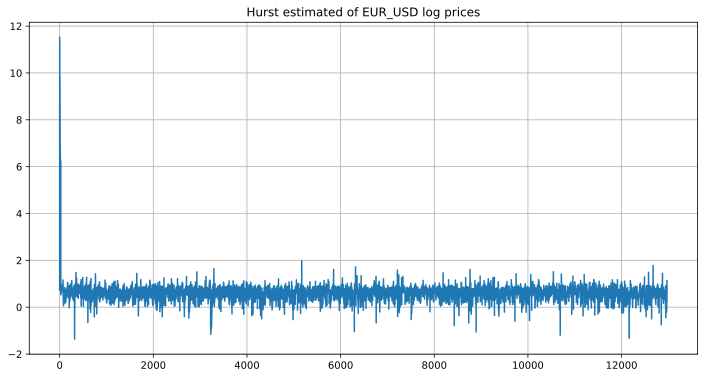

In [58]:
# for each series, we compute a raw estimate of the Hurst exponent using 25-obersvation windows
data_hurst_estimated = {}
for serie in data_forex:
    data_hurst_estimated[serie] = computing_h_estimated(2, 25, data_forex[serie].values)

plt.figure(figsize=FIGSIZE)
plt.plot(data_hurst_estimated[serie_])
plt.title('Hurst estimated of ' + serie_ + ' log prices')
plt.grid()
plt.show()

## 2.3 Smoothing the raw series on a sample of 50 consecutive raw estimates

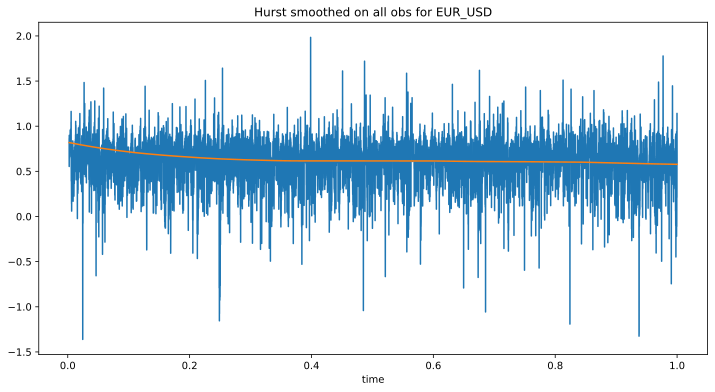

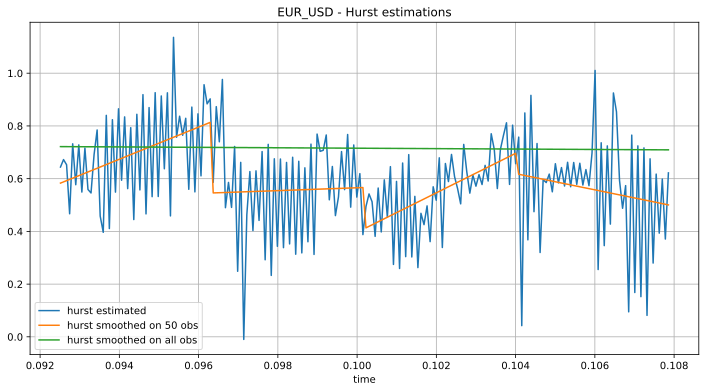

In [59]:
data_hurst_smoothed = {}

N_OBS = len(data_forex[serie_].values) 
t_interval = np.linspace(0, 1, N_OBS)
phi_h_estimated_serie = computing_phi_H_estimated(LAMBDA, data_hurst_estimated[serie_], t_interval)

matrix_H_smoothed = np.zeros((N_OBS - 50, 50))
for i in range(0, N_OBS-50):
    #print(i, flush=True)
    matrix_H_smoothed[i,:] = computing_H_smoothed(t_interval, LAMBDA, data_hurst_estimated[serie_], phi_h_estimated_serie, start_window=i, n_window=50+i).ravel()
    
data_hurst_smoothed[serie_] = matrix_H_smoothed

# test on smoothing the whole serie : 
test_smooth_all = computing_H_smoothed(t_interval, LAMBDA, data_hurst_estimated[serie_], phi_h_estimated_serie, n_window= N_OBS).ravel()

plt.figure(figsize=FIGSIZE)
plt.plot(t_interval[30:], data_hurst_estimated[serie_][30:])
plt.plot(t_interval[30:], test_smooth_all[30:]),
plt.title('Hurst smoothed on all obs for ' + serie_)
plt.xlabel('time')
plt.show()

# test affichage sur periodes 1200:1400
test_smooth_period = np.concatenate((matrix_H_smoothed[1200], matrix_H_smoothed[1250]))
test_smooth_period = np.concatenate((test_smooth_period, matrix_H_smoothed[1300]))
test_smooth_period = np.concatenate((test_smooth_period, matrix_H_smoothed[1350]))

plt.figure(figsize=FIGSIZE)
plt.plot(t_interval[1200:1400], data_hurst_estimated[serie_][1200:1400])
plt.plot(t_interval[1200:1400], test_smooth_period)
plt.plot(t_interval[1200:1400], test_smooth_all[1200:1400])
plt.title( serie_ + ' - Hurst estimations')
plt.xlabel('time')
plt.legend(['hurst estimated', 'hurst smoothed on 50 obs', 'hurst smoothed on all obs'], loc='best')
plt.grid()
plt.show()

## 2.4 Forecast Hurst exponent at time t by a quadratic extrapolation

In [18]:
hurst_smoothed_forecast = np.zeros((N_OBS - 50 - 1))

for i in range(50 + 1, N_OBS):
    hurst_smoothed_forecast[i - 50 - 1] = (5/2) * data_hurst_smoothed[serie_][i-50-1][-1] - 2*data_hurst_smoothed[serie_][i-50-1][-2] + 0.5 * data_hurst_smoothed[serie_][i-50-1][-3]

hurst_smoothed_real = np.asarray([data_hurst_smoothed[serie_][i][-1] for i in range(1, N_OBS-50)])

result_diff_forecast = hurst_smoothed_forecast - hurst_smoothed_real
mean_difference = result_diff_forecast.mean()
print('difference moyenne entre les exposants de Hurst prévus et réalisés pour la série ' + serie_ + ': ' ,mean_difference)

difference moyenne entre les exposants de Hurst prévus et réalisés pour la série EUR_USD:  -0.00041183015055534046


## 2.5 Validation des previsions : Hit ratio

In [19]:
# count the proportion of times that forecast exchange rate evolution has the same sign than the real one 
count = 0

for i in range(0, len(hurst_smoothed_forecast) - 1 ):
    evolution_forecast = hurst_smoothed_forecast[i] - hurst_smoothed_forecast[i + 1]
    evolution_real = hurst_smoothed_real[i] - hurst_smoothed_real[i + 1]
    
    if (evolution_forecast > 0) and (evolution_real > 0):
        count = count + 1
    elif (evolution_forecast < 0) and (evolution_real < 0):
        count = count + 1
    else:
        pass

import scipy
from scipy.stats import binomtest
p_value = binomtest(count, len(hurst_smoothed_forecast) - 1, 0.5)

print('Le hit ratio pour ' + serie_ + ':', (count/len(hurst_smoothed_forecast))*100)
print('p value du test binomial pour ' + serie_ + ':', p_value)


Le hit ratio pour EUR_USD: 45.37574491138457
p value du test binomial pour EUR_USD: BinomTestResult(k=5863, n=12920, alternative='two-sided', statistic=0.4537925696594427, pvalue=8.362567094994447e-26)
